# Sandbox for comparing Bayesian inference with multiple constraints and systematic errors

In [1]:
from collections import OrderedDict

In [2]:
from matplotlib import pyplot as plt

In [3]:
import numpy as np
from scipy import stats
from scipy.stats import invgamma, norm

In [4]:
import corner

In [5]:
import rxmc

Using database version X4-2024-12-31 located in: /home/beyerk/db/exfor/unpack_exfor-2024/X4-2024-12-31


In [6]:
true_params = OrderedDict(
    [
        ("m", 2),
        ("b", 4),
    ]
)

In [7]:
rng = np.random.default_rng(42)

In [8]:
class LinearModel(rxmc.physical_model.PhysicalModel):
    def __init__(self):
        params = [
            rxmc.params.Parameter("m", float, "no-units"),
            rxmc.params.Parameter("b", float, "y-units"),
        ]
        super().__init__(params)

    def evaluate(self, observation, m, b):
        return self.y(observation.x, m, b)

    def y(self, x, m, b):
        # useful to have a function hat takes in an array-like x
        # rather than an Observation, e.g. for plotting
        return m * x + b

In [9]:
my_model = LinearModel()

In [10]:
x_grid = np.linspace(0.00, 1, 20)
y_true_grid = my_model.y(x_grid, *list(true_params.values()))

In [11]:
def generate_observation(
    x,
    reported_statistical_err=0.0,
    reported_normalization_err=0.0,
    reported_offset_err=0.0,
    actual_statistical_err=0.0,
    actual_normalization=1.0,
    actual_offset=0.0,
):
    y_true = my_model.y(x, *list(true_params.values()))
    y_exp = (
        rng.normal(loc=y_true, scale=actual_statistical_err) * actual_normalization
        + actual_offset
    )
    obs = rxmc.observation.Observation(
        x=x,
        y=y_exp,
        y_stat_err=reported_statistical_err * np.ones_like(y_exp),
        y_sys_err_normalization=reported_normalization_err,
        y_sys_err_offset=reported_offset_err,
    )
    return obs, y_true

In [12]:
x1 = rng.random(10)
obs1, _ = generate_observation(
    x1,
    reported_statistical_err=0.1,
    actual_statistical_err=0.1,
    actual_offset=1,
    # reported_offset_err=1
)

# x2 = rng.random(10)
x2 = x1
obs2, _ = generate_observation(
    x2,
    reported_statistical_err=0.1,
    actual_statistical_err=0.1,
    actual_offset=-1,
    #  reported_offset_err=1
)

Text(0, 0.5, '$y$')

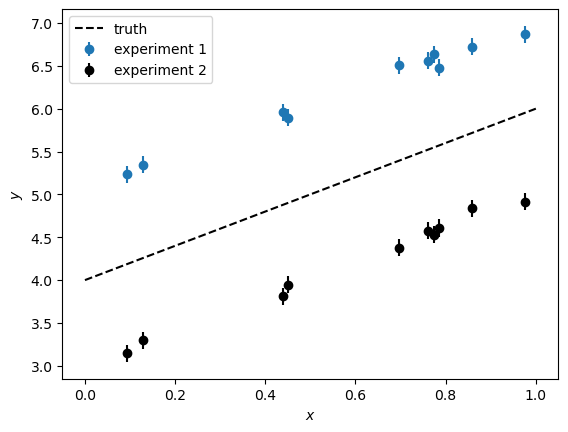

In [13]:
plt.errorbar(
    obs1.x,
    obs1.y,
    np.diag(np.sqrt(obs1.statistical_covariance)),
    marker="o",
    linestyle="none",
    label="experiment 1",
)
plt.errorbar(
    obs2.x,
    obs2.y,
    np.diag(np.sqrt(obs2.statistical_covariance)),
    color="k",
    marker="o",
    linestyle="none",
    label="experiment 2",
)

plt.plot(x_grid, y_true_grid, "k--", label="truth")
plt.legend()
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")

In [14]:
prior_mean = true_params
prior_std_dev = OrderedDict(
    [
        ("m", 1),
        ("b", 1),
    ]
)

In [15]:
covariance = np.diag(list(prior_std_dev.values())) ** 2
mean = np.array(list(prior_mean.values()))
prior_distribution = stats.multivariate_normal(mean, covariance)

In [16]:
likelihood = rxmc.likelihood_model.LikelihoodModel()

In [17]:
evidence = rxmc.evidence.Evidence(
    [
        rxmc.constraint.Constraint(
            [obs1],
            my_model,
            likelihood,
        ),
        rxmc.constraint.Constraint(
            [obs2],
            my_model,
            likelihood,
        ),
    ]
)

In [18]:
def proposal_distribution(x, rng):
    return stats.multivariate_normal.rvs(
        mean=x, cov=prior_distribution.cov / 100, random_state=rng
    )

In [20]:
sampling_config = rxmc.param_sampling.MetropolisHastingsSampler(
    params=my_model.params,
    starting_location=prior_distribution.mean,
    proposal=proposal_distribution,
    prior=prior_distribution,
)

In [21]:
walker = rxmc.walker.Walker(
    sampling_config,
    evidence,
)

## Plot likelihood surface

In [22]:
lm = walker.evidence.constraints[0].likelihood

In [23]:
b_grid = np.linspace(0, 8, 100)

In [24]:
print([p.name for p in my_model.params])

['m', 'b']


In [25]:
logl = [walker.evidence.log_likelihood((true_params["m"], b)) for b in b_grid]

In [26]:
logl1 = np.array(
    [
        walker.evidence.constraints[0].log_likelihood((true_params["m"], b))
        for b in b_grid
    ]
)
logl2 = np.array(
    [
        walker.evidence.constraints[1].log_likelihood((true_params["m"], b))
        for b in b_grid
    ]
)

Text(0, 0.5, '$\\log \\mathcal{L}( y_{exp} \\, | \\, b, m = m_{\\rm{true}})$')

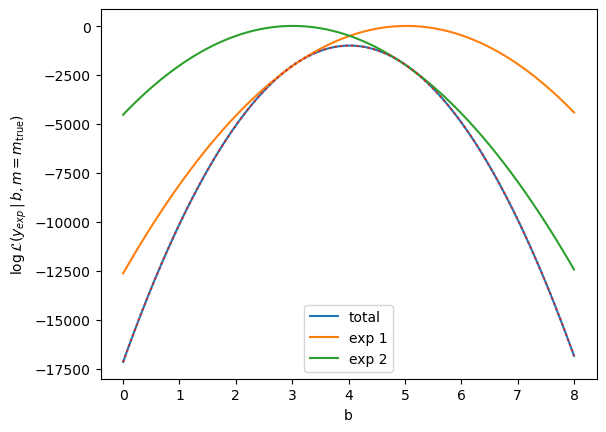

In [27]:
plt.plot(b_grid, logl, label="total")
plt.plot(b_grid, logl1, label="exp 1")
plt.plot(b_grid, logl2, label="exp 2")
plt.plot(b_grid, logl1 + logl2, ":")

plt.legend()
plt.xlabel("b")
plt.ylabel(r"$\log \mathcal{L}( y_{exp} \, | \, b, m = m_{\rm{true}})$")

In [28]:
%%time
walker.walk(n_steps=10000, burnin=1000)

Burn-in batch 1/1 completed, 1000 steps.
Batch: 1/1 completed, 10000 steps. 
  Model parameter acceptance fraction: 0.178
CPU times: user 3.98 s, sys: 6.7 ms, total: 3.99 s
Wall time: 3.99 s


0.1782

In [29]:
def plot_chains(walker, model, true_params):
    fig, axes = plt.subplots(
        walker.model_chain.shape[1] + 1, 1, figsize=(8, 8), sharex=True
    )
    for i in range(walker.model_chain.shape[1]):
        axes[i].plot(walker.model_chain[:, i])
        axes[i].set_ylabel(f"${model.params[i].latex_name}$ [{model.params[i].unit}]")
        true_value = true_params[model.params[i].name]
        axes[i].hlines(true_value, 0, len(walker.model_chain), "r", linestyle="--")

    axes[-1].plot(walker.log_posterior_record)
    axes[-1].set_ylabel(r"$\log{\mathcal{L}(\alpha_i | \mathcal{O})}$")

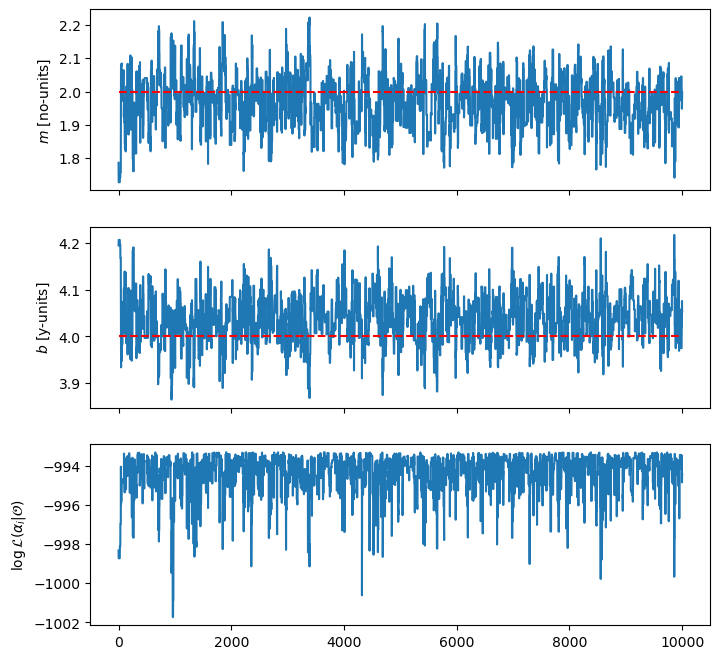

In [30]:
plot_chains(walker, my_model, true_params)

In [31]:
def plot_posterior_corner(walker):
    fig = corner.corner(
        walker.model_chain,
        labels=[p.name for p in my_model.params],
        label="posterior",
        truths=[true_params["m"], true_params["b"]],
    )

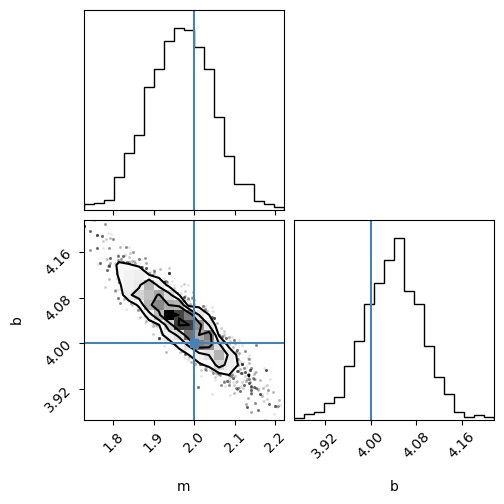

In [32]:
plot_posterior_corner(walker)

In [33]:
def plot_predictive_post(walker, model):
    n_posterior_samples = walker.model_chain.shape[0]
    y = np.zeros((n_posterior_samples, len(x_grid)))
    for i in range(n_posterior_samples):
        sample = walker.model_chain[i, :]
        y[i, :] = model.y(x_grid, *sample)

    upper, lower = np.percentile(y, [5, 95], axis=0)
    plt.fill_between(
        x_grid,
        lower,
        upper,
        alpha=0.5,
        zorder=2,
        label=r"posterior inner 90$^\text{th}$ pctl",
    )
    plt.errorbar(
        obs1.x,
        obs1.y,
        np.diag(np.sqrt(obs1.statistical_covariance)),
        marker="o",
        linestyle="none",
        label="experiment 1",
    )
    plt.errorbar(
        obs2.x,
        obs2.y,
        np.diag(np.sqrt(obs2.statistical_covariance)),
        color="k",
        marker="o",
        linestyle="none",
        label="experiment 2",
    )

    plt.plot(x_grid, y_true_grid, "k--", label="truth")
    plt.legend()
    plt.xlabel(r"$x$")
    plt.ylabel(r"$y$")

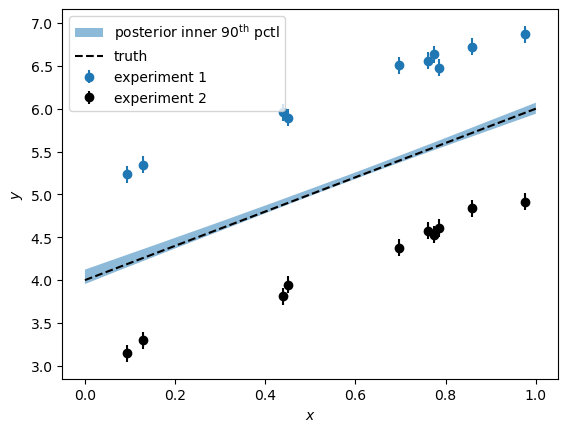

In [34]:
plot_predictive_post(walker, my_model)